![](images/2021-11-18-movie-projector.jpg){fig-align="center"}

<center><a href = "https://unsplash.com/photos/MAYsdoYpGuk">Unsplash | Alex Litvin</a></center>

# Overview

Fandango is a website that sells tickets for movies. For each movie, the site provides a synopsis as well as an aggregated rating from 0.0 to 5.0.

A [data journalism piece](https://fivethirtyeight.com/features/fandango-movies-ratings/) (Hickey, 2015) investigated Fandango's rating system. By comparing the displayed ratings to those in the website's code, it found that almost half of the displayed ratings were rounded up inappropriately. Thus, most movies had a rating of at least 3 stars. Furthermore, Fandango's ratings were generally higher than those of other movie rating websites. This implied that Fandango may have altered its ratings in order to encourage people to purchase its tickets.

The present project aimed to determine whether the distribution of ratings has changed from the time of Hickey's analysis. Thus, the data used by Hickey was compared to more recent data from 2016. Furthermore, basic statistical concepts and hypothesis testing were applied in this project. The Mann-Whitney U rank test for independent samples showed that the distribution of 2015 ratings was significantly higher than that of 2016 ratings (p < 0.001).

:::{.callout-note}

I wrote this notebook by following a guided project on the [Dataquest](https://www.dataquest.io/) platform, specifically the [Guided Project: Investigating Fandango Movie Reviews](https://app.dataquest.io/c/53/m/288/guided-project%3A-investigating-fandango-movie-ratings/1/is-fandango-still-inflating-ratings). The general project flow and research questions came from Dataquest. However, all of the text and code here are written by me unless stated otherwise.

:::

# Preparations

Below are the imports used for this project.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Population and Samples

Given the project goal, there were two populations of interest:

- All movies released in 2015 with ratings on Fandango.
- All movies released in 2016 with ratings on Fandango. 

However, the two datasets available included only samples of this population. These datasets were taken from [Dataquest](https://app.dataquest.io/c/53/m/288/guided-project%3A-investigating-fandango-movie-ratings/2/understanding-the-data).

Dataset A was `fandango_score_comparison.csv`. It included movies released in 2014-2015 that had at least 30 reviews as of mid-2015. These amounted to 146 movies. The data dictionary, which explains the meanings of the data columns, can be found [here](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md).

Dataset B was `movie_ratings_16_17.csv`. It included 214 of the most popular movies released in 2016-2017. The ratings provided are from 2017. The data dictionary is [here](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md).

Given the descriptions of the two samples, it was clear that the sampling was not random. Certain criteria, such as the number of reviews or the popularity of the movie, were used to select movies. Therefore, the samples did not truly represent the populations of interest, which include *all of the movies* released in each year.

Therefore, the goal of the project was adjusted to account for the samples. We then sought to determine whether the distribution of Fandango ratings for popular movies in 2015 was similar to the distribution of Fandango ratings for popular movies in 2016. This new goal only considers "popular" movies, not all available movies.

However, "popularity" had to be given a precise definition. Since this could not be directly measured, the benchmark used in Hickey's analysis was used in this project. That is, all movies with *at least 30 ratings* were considered as "popular" movies.

# Data Cleaning

Based on the adjusted goal of the project, the datasets were cleaned to get samples representative of the populations.

First, only movies released in 2015 were taken from Dataset A, and only movies released in 2016 were taken from Dataset B.

The next concern was that Dataset B did not provide the number of reviews, so the benchmark of having at least 30 reviews could not be used to identify objectively popular movies. However, it was possible to assume that all of the movies in Dataset B were popular. The person who scraped the data, Alex Olteanu, stated that he took the "most voted and reviewed" movies released in 2016 and 2017 [(Olteanu, 2017)](https://www.freecodecamp.org/news/whose-reviews-should-you-trust-imdb-rotten-tomatoes-metacritic-or-fandango-7d1010c6cf19/).

The code below cleaned the data based on the above requirements, then printed the final sizes of the samples.

In [4]:
#| code-fold: true
folder = "./private/2021-11-18-Fandango-Ratings-Files"

# Obtain full data, which includes ratings from various sites
df_a_all = pd.read_csv(folder + "/fandango_score_comparison.csv")
df_b_all = pd.read_csv(folder + "/movie_ratings_16_17.csv")

# Dataset A: Take only the data from Fandango, not other sites
df_a = df_a_all[[
    "FILM",
    "Fandango_Stars",
    "Fandango_Ratingvalue",
    "Fandango_votes",
    "Fandango_Difference",
]].copy()

# Create a column of release years based on the FILM column
df_a.loc[:, "year"] = (
    df_a
    .loc[:, "FILM"]
    .str.extract(r"\((201[45])\)$")
    .astype(int, errors = "ignore")
)

# Take movies from 2015
df_a = df_a.loc[df_a["year"] == 2015]

# Dataset B: Take only data from Fandango, not other sites
df_b = df_b_all[[
    "movie",
    "year",
    "fandango",
]].copy()

# Take movies from 2016
df_b = df_b.loc[df_b["year"] == 2016]

print("Number of 2015 movies:", df_a.shape[0])
print("Number of 2016 movies:", df_b.shape[0])

Number of 2015 movies: 129
Number of 2016 movies: 191


The sample sizes decreased because movies released in 2014 and 2017 were excluded.

The first 5 entries in Dataset A, from 2015, were shown below.

In [5]:
#| code-fold: true
df_a.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


The `FILM` column gives the name of the film. `Fandango_Ratingvalue` is the hidden rating found in the website's HTML, whereas `Fandango_Stars` is the value that was displayed on the webpages.

On the other hand, Dataset B only contained displayed ratings. The hidden ratings had been removed from the HTML before this dataset was collected.

In [6]:
#| code-fold: true
df_b.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0


In both datasets, it may be observed that the displayed ratings were rounded to the nearest half-star from their original values.

# Analysis

The goal was to determine whether the two samples have a similar distribution. Thus, a kernel density estimation (KDE) plot was used to visualize the distributions. KDE plots are similar to histograms, but these are smooth and continuous. The y-axis represents the approximated *probability density* at a particular value of x. [(Waskom, 2021)](http://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde)

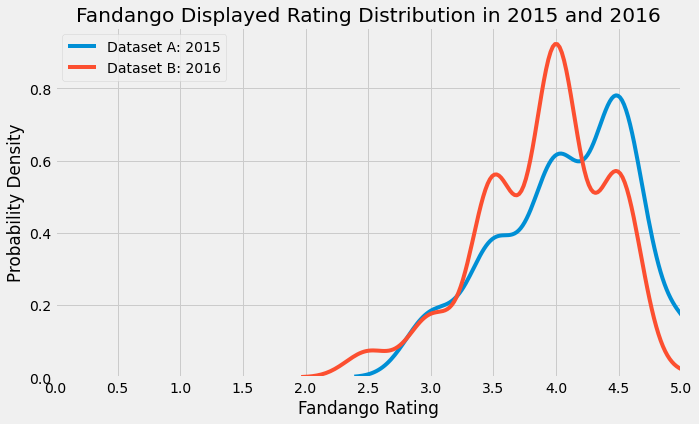

In [7]:
#| code-fold: true
plt.style.use('fivethirtyeight')

plt.figure(figsize = (10, 6))

sns.kdeplot(
    data = df_a,
    x = "Fandango_Stars",
    label = "Dataset A: 2015",
)

sns.kdeplot(
    data = df_b,
    x = "fandango",
    label = "Dataset B: 2016"
)

plt.title("Fandango Displayed Rating Distribution in 2015 and 2016")

plt.xlabel("Fandango Rating")
# Limit the x-axis to [0, 5] because this is the range of ratings
plt.xlim(0, 5)
# Show ticks in 0.5 intervals
plt.xticks(np.arange(0.0, 5.5, 0.5))

plt.ylabel("Probability Density")

plt.legend()

plt.show()

In the KDE plot above, the blue line represents the distribution of 2015 displayed ratings. On the other hand, the red line represents the distribution of 2016 displayed ratings. The hidden ratings from 2015 were excluded from this plot because these did not directly influence Fandango customers' ticket-purchasing decisions, unlike the displayed ratings.

Both distributions were left-skewed. There were more high ratings than low ratings. However, the 2015 ratings noticeably had a higher mode, which was near 4.5. In general, the whole 2015 distribution seemed to be shifted to the right of the 2016 distribution. Therefore, it seemed that movies generally had higher Fandango ratings in 2015 than 2016.

In order to get more specific numbers, frequency tables were generated.

In [8]:
#| code-fold: true
# Create a frequency table for Dataset B (2016)
freq_b = df_b["fandango"].value_counts(bins = 10).sort_index()
freq_b.name = "2016"

# Use the bins in the B table for the A table
freq_a = {}

for rating in df_a["Fandango_Stars"]:
    for rng in freq_b.index:
        if rating in rng:
            freq_a.setdefault(rng, 0)
            freq_a[rng] += 1
            
freq_a = pd.Series(freq_a, name = "2015")

# Combine the tables into one
freq_both = (
    pd.DataFrame(freq_b)
    .merge(
        freq_a,
        how = "left",
        left_index = True,
        right_index = True,
    )
    .fillna(0)
    .loc[:, ["2015", "2016"]]
)

# Display the table
print("Number of ratings per interval of 0.25 stars")
freq_both

Number of ratings per interval of 0.25 stars


,2015,2016
"(2.4970000000000003, 2.75]",0.0,6
"(2.75, 3.0]",11.0,14
"(3.0, 3.25]",0.0,0
"(3.25, 3.5]",23.0,46
"(3.5, 3.75]",0.0,0
"(3.75, 4.0]",37.0,77
"(4.0, 4.25]",0.0,0
"(4.25, 4.5]",49.0,47
"(4.5, 4.75]",0.0,0
"(4.75, 5.0]",9.0,1


The table shows that:

- There were 11 more ratings above 4.25 in 2015 than in 2016.
- There were 72 fewer ratings below 4.25 in 2015 than in 2016.

This further supported the observation that Fandango's displayed ratings were generally higher in 2015 than in 2016.

In order to determine whether this difference was statistically significant, hypothesis testing for two independent samples was used. Since the two distributions both looked left-skewed rather than normal, it was appropriate to use the Mann-Whitney U rank test. According to [NCSS](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Two-Sample_T-Test.pdf) (n.d.), this is a nonparametric test with the following assumptions:

- **The variable is continuous, or at least ordinal.** Both datasets contained rounded mean ratings, so these followed an ordinal distribution with intervals of 0.5.
- **The two populations' distributions are identical except for location.** One may occupy a higher range than the other. This was fulfilled because all of the ratings came from Fandango. It was expected that the ratings would be consistently left-skewed, especially since there was only a one-year gap between our two populations.
- **The two samples are independent.** This was true because there was no movie that existed in both datasets. Dataset A only contained movies released in 2015, and Dataset B only contained movies released in 2016.
- **The samples are simple random samples.** It was not certain that the people who collected the data chose totally randomly from a list of popular movies. However, since this is the best data available, it had to be used.

Let the distribution of Dataset A be F(u), and that of Dataset B be G(u). The alternative hypothesis was that F(u) > G(u). The test was performed below using the Scipy package.

In [9]:
#| code-fold: true
U1, p = mannwhitneyu(
    df_a["Fandango_Stars"],
    df_b["fandango"],
    # Alternative hypothesis
    alternative = "greater",
    # Adjust for ties
    method = "asymptotic",
)

print(f"U1 statistic: {U1}")
print(f"p-value: {p}")

U1 statistic: 14871.5
p-value: 0.000516222939793581


The $U$ statistic is the "the total number of times an observation in one group is 
preceded by an observation in the other group in the ordered configuration of combined samples (Gibbons, 1985)[.]" (NCSS, n.d.)

In this case, $U_1$ was the $U$ statistic of Dataset A with respect to Dataset B. Therefore, for around 14871.5 times, an observation in A was preceded by an observation in B. This was rather high, considering that each sample only had a few hundred observations.

More importantly, the p-value was approximately 0.0005. Therefore, the difference between the two populations was significant at $\alpha = 0.001$. The distribution of ratings in 2015 was significantly greater than that in 2016.

# Conclusion

A KDE plot, frequency table, and Mann-Whitney U rank test were used to investigate the Fandango ratings of popular movies. Based on the results, the alternative hypothesis is accepted. The ratings displayed in 2015 were significantly higher than those in 2016 (p < 0.001).

The implication is that Fandango may have investigated the issues raised in Hickey's analysis and fixed their displayed ratings. They may have stopped the numbers from being rounded up excessively, so the 2016 ratings ended up being lower than the 2015 ratings.

# Bibliography

## Information Sources

Details for Non-Parametric Alternatives in Case C-Q. (2021). In Biostatistics Open Learning Textbook. University of Florida. https://bolt.mph.ufl.edu/6050-6052/unit-4b/module-13/details-for-non-parametric-alternatives/

Guided Project: Investigating Fandango Movie Ratings. (n.d.). Dataquest. Retrieved November 18, 2021, from https://www.dataquest.io/c/53/m/288/guided-project%3A-investigating-fandango-movie-ratings

Hickey, W. (2015, October 15). Be Suspicious Of Online Movie Ratings, Especially Fandango’s. FiveThirtyEight. https://fivethirtyeight.com/features/fandango-movies-ratings/

LaMorte, W. W. (2017, May 4). Mann-Whitney-Table-CriticalValues.pdf. Boston University School of Public Health. https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Nonparametric/Mann-Whitney-Table-CriticalValues.pdf

NCSS. (n.d.). Chapter 206 Two-Sample T-Test. NCSS Statistics Solutions. Retrieved November 18, 2021, from https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Two-Sample_T-Test.pdf

scipy.stats.mannwhitneyu—SciPy v1.7.1 Manual. (2021). Scipy. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

Waskom, M. (2021). Visualizing distributions of data—Seaborn 0.11.2 documentation. Seaborn. http://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde

## Image Sources

Litvin, A. (2018, August 23). Photo by Alex Litvin on Unsplash. Unsplash. https://unsplash.com/photos/MAYsdoYpGuk